<a href="https://colab.research.google.com/github/nikxlvii/explainable-ai/blob/main/Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as Transform

In [3]:
transform = Transform.Compose(
    [Transform.ToTensor(),
     Transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [4]:
batch_size = 4

train_set = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform = transform)
test_set = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform = transform)


trainloader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=3)
testloader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=3)

100%|██████████| 170498071/170498071 [00:01<00:00, 86052938.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# making a convolutional neural network

import torch.nn as nn
import torch.nn.functional as F

class NeuNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

net = NeuNet()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.9)

In [8]:
for epoch in range(2):

  running_loss = 0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 2000 == 1999:
      print(f'[{epoch + 1},{i + 1: 5d}] loss: {running_loss/2000:.3f}')
      running_loss = 0.0

print('Finished Training')

[1, 2000] loss: 2.255
[1, 4000] loss: 1.914
[1, 6000] loss: 1.702
[1, 8000] loss: 1.575
[1, 10000] loss: 1.499
[1, 12000] loss: 1.450
[2, 2000] loss: 1.381
[2, 4000] loss: 1.370
[2, 6000] loss: 1.345
[2, 8000] loss: 1.309
[2, 10000] loss: 1.285
[2, 12000] loss: 1.269
Finished Training


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

images,labels

(tensor([[[[-0.0667, -0.0510,  0.0510,  ...,  0.5686,  0.5765,  0.6314],
           [ 0.0353,  0.0510,  0.2157,  ...,  0.6471,  0.6627,  0.7255],
           [ 0.1294,  0.2392,  0.3647,  ...,  0.7333,  0.7569,  0.7647],
           ...,
           [-0.2549, -0.2000, -0.1373,  ..., -0.6235, -0.5608, -0.5529],
           [-0.2471, -0.2157, -0.1765,  ..., -0.6784, -0.6157, -0.5529],
           [-0.2627, -0.2627, -0.3020,  ..., -0.6471, -0.6314, -0.5686]],
 
          [[-0.0667, -0.0510,  0.0510,  ...,  0.5686,  0.5765,  0.6314],
           [ 0.0353,  0.0510,  0.2157,  ...,  0.6471,  0.6627,  0.7255],
           [ 0.1294,  0.2392,  0.3647,  ...,  0.7333,  0.7569,  0.7647],
           ...,
           [-0.2549, -0.2000, -0.1373,  ..., -0.6235, -0.5608, -0.5529],
           [-0.2471, -0.2157, -0.1765,  ..., -0.6784, -0.6157, -0.5529],
           [-0.2627, -0.2627, -0.3020,  ..., -0.6471, -0.6314, -0.5686]],
 
          [[-0.0667, -0.0510,  0.0510,  ...,  0.5686,  0.5765,  0.6314],
           [ 

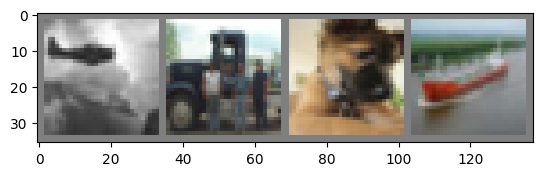

GroundTruth:  plane truck dog   ship 


In [11]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane horse frog  ship 


In [14]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images,labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the 10000 test images: 55 %


In [15]:
# counting predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.5 %
Accuracy for class: car   is 77.5 %
Accuracy for class: bird  is 20.7 %
Accuracy for class: cat   is 29.6 %
Accuracy for class: deer  is 56.5 %
Accuracy for class: dog   is 59.9 %
Accuracy for class: frog  is 70.6 %
Accuracy for class: horse is 65.0 %
Accuracy for class: ship  is 62.2 %
Accuracy for class: truck is 58.8 %


In [18]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [19]:
net.eval()

NeuNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
!pip install captum

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00


In [21]:
def attribute_image_features(algorithm,input,**kwargs):
  net.zero_grad()
  tensor_attributions = algorithm.attribute(input,target = labels[ind],**kwargs)
  return tensor_attributions

In [24]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [25]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1166], dtype=torch.float64)


Original Image
Predicted: frog  Probability: 0.9719582200050354


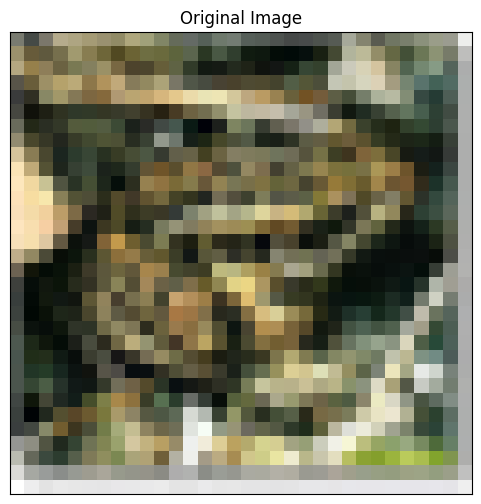

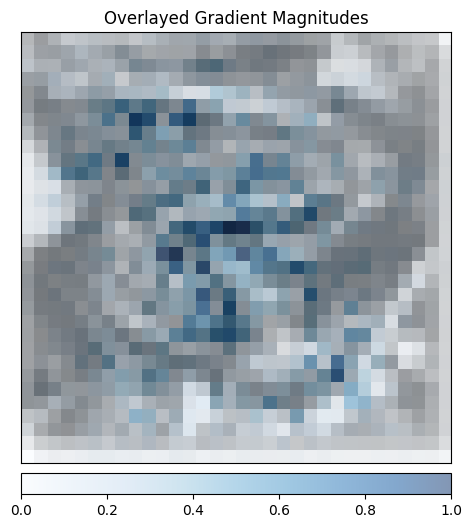

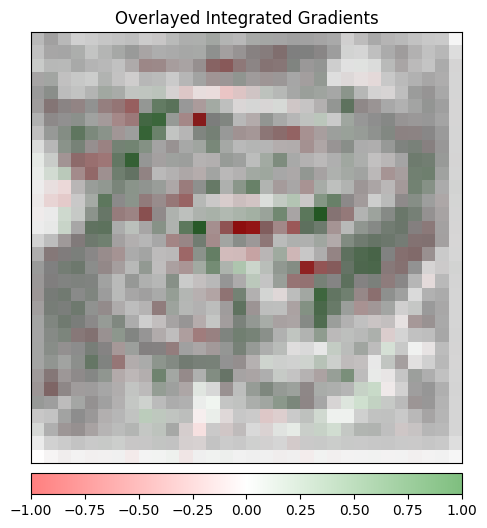

In [28]:
print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

The model says that there is a 97% chance that the image is of a frog.